# The Language Model

## 1. Demonstration

### Source Rewriter

Given the following example code (taken from Nvidia’s streamcluster benchmark):

In [1]:
code = """//#define Elements
__kernel void memset_kernel(__global char * mem_d, short val, int number_bytes){
    const int thread_id = get_global_id(0);
    mem_d[thread_id] = val;
}"""

print(code)

//#define Elements
__kernel void memset_kernel(__global char * mem_d, short val, int number_bytes){
    const int thread_id = get_global_id(0);
    mem_d[thread_id] = val;
}


We apply the rewriter. Variable and function names are normalized, comments removed, and code style enforced:

In [2]:
from clgen import preprocess

rewritten = preprocess(code)
print(rewritten)

/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/elandg/eecs583-pape

__kernel void A(__global char* a, short b, int c) {
  const int d = get_global_id(0);
  a[d] = b;
}


### Source Encoder

Deriving a 1-of-$k$ vocabulary for a piece of code, using a hybrid character and token based approach:

In [3]:
from clgen._atomizer import GreedyAtomizer
from clgen._langs import Language


atomizer = GreedyAtomizer.from_text(lang=Language.from_str("opencl"), text=rewritten)
print(atomizer)

GreedyAtomizer[27 tokens]


The derived vocabulary maps tokens to indices:

In [4]:
import pandas as pd

pd.DataFrame(sorted([f"'{k}'" for k in atomizer.vocab]), columns=["token"])

,token
0,'\n'
1,' '
2,' '
3,'('
4,')'
5,'*'
6,"','"
7,'0'
8,';'
9,'='


Encoding the source using this vocabulary yields:

In [5]:
encoded = atomizer.atomize(rewritten)
print(encoded)

[14  1 24  1 10  3 13  1 18  5  1 15  6  1 23  1 16  6  1 22  1 17  4  1
 25  0  2 19  1 22  1 20  1  9  1 21  3  7  4  8  0  2 15 11 20 12  1  9
  1 16  8  0 26]


Reversing the process:

In [6]:
for i in encoded:
    t = atomizer.deatomize([i])
    if t == '\n': t = '\\n'
    print(f"<{t}>", end="")

<__kernel>< ><void>< ><A><(><__global>< ><char><*>< ><a><,>< ><short>< ><b><,>< ><int>< ><c><)>< ><{><\n><  ><const>< ><int>< ><d>< ><=>< ><get_global_id><(><0><)><;><\n><  ><a><[><d><]>< ><=>< ><b><;><\n><}>

### Padding

Sequences are padded to a fixed length using an out-of-vocabulary token:

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

pad_val = atomizer.vocab_size
print(pad_sequences([encoded], maxlen=len(encoded) + 22, value=pad_val)[0])

[27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 27 14  1
 24  1 10  3 13  1 18  5  1 15  6  1 23  1 16  6  1 22  1 17  4  1 25  0
  2 19  1 22  1 20  1  9  1 21  3  7  4  8  0  2 15 11 20 12  1  9  1 16
  8  0 26]


## 2. Deriving Vocabulary from Handwritten GPGPU Benchmarks

For the experiments in the paper, we derived a vocabulary from 45k lines of real world handwritten GPGPU benchmarks:

In [8]:
import pandas as pd

srcs = '\n'.join(pd.read_csv("../data/case-study-a/cgo17-amd.csv")['src'].values)
print("lines of code:", len(srcs.split('\n')))

derived_atomizer = GreedyAtomizer.from_text(lang=Language.from_str("opencl"), text=srcs)
print("derived vocabulary:", derived_atomizer)

lines of code: 45497
derived vocabulary: GreedyAtomizer[128 tokens]


In [9]:
pd.set_option('display.max_rows', 10)
pd.DataFrame(sorted([f"'{k}'" for k in derived_atomizer.vocab]), columns=["token"])

,token
0,'\n'
1,' '
2,' '
3,'!'
4,'%'
...,...
123,'y'
124,'z'
125,'{'
126,'|'


Using this derived vocabulary, lets plot the first 80 tokens of 12 real world GPU benchmarks:

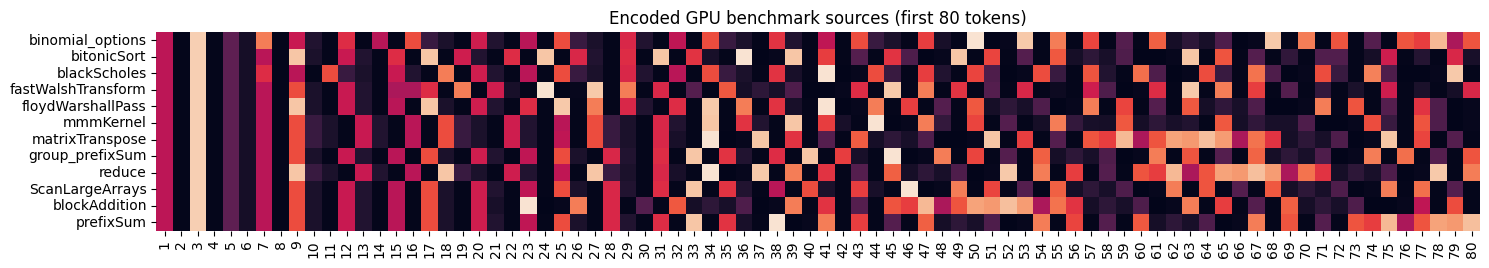

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from labm8 import viz

natoms = 80
nprog = 12

data = [derived_atomizer.atomize(src)[:natoms] for src in
        pd.read_csv("../data/case-study-a/cgo17-amd.csv")['src'].values[:nprog]]
kernels = [x.split("-")[-1] for x in
           pd.read_csv("../data/case-study-a/cgo17-amd.csv")['benchmark'].values[:nprog]]
data = np.reshape(data, (nprog, natoms))
    
ax = sns.heatmap(data, vmin=0, vmax=derived_atomizer.vocab_size, square=True,
                 cbar=False, yticklabels=kernels, xticklabels=[str(x) for x in range(1, natoms + 1)])
plt.title("Encoded GPU benchmark sources (first 80 tokens)")
viz.finalise(figsize=(15, 5))

Notice that, as a result of the rewriting process, each of the kernels starts in an identical manner, i.e. `__kernel void A(...`

# 3. Reproduce LaTeX Tables from the Paper

Order the atoms by their appearance in the example code:

In [11]:
i = 1
s = set()
ordered = []
for idx in derived_atomizer.atomize(rewritten):
    if idx not in s:
        t = derived_atomizer.decoder[idx]
        ordered.append((idx, t, i))
        i += 1
        s.add(idx)

Table 3c:

In [12]:
print("""
\\footnotesize
\\begin{tabular}{l l | l l | l l}
  \\toprule\
""")
print(" ", " & ".join(["\\textbf{idx} & \\textbf{token}"] * 3), "\\\\")
print("  \\midrule")

def escape(x):
    import re
    if x == '\n':
        return '\\textbackslash n'
    elif x == '{':
        return '\\{'
    elif x == '}':
        return '\\}'
    else:
        return re.sub(r'_', '\\_', x)

for i, (j, k, l) in enumerate(zip(ordered[:9], ordered[9:18], ordered[18:])):
    i1, i2, i3 = i + 1, i + 10, i + 19
    c1, c2, c3 = escape(j[1]), escape(k[1]), escape(l[1])
    print(f"""  \
\\texttt{{{i1}}} & \\texttt{{`{c1}'}} & \
\\texttt{{{i2}}} & \\texttt{{`{c2}'}} & \
\\texttt{{{i3}}} & \\texttt{{`{c3}'}} \\\\\
""")
    
print("""\
  \\bottomrule
\\end{tabular}""")


\footnotesize
\begin{tabular}{l l | l l | l l}
  \toprule
  \textbf{idx} & \textbf{token} & \textbf{idx} & \textbf{token} & \textbf{idx} & \textbf{token} \\
  \midrule
  \texttt{1} & \texttt{`\_\_kernel'} & \texttt{10} & \texttt{`,'} & \texttt{19} & \texttt{`const'} \\
  \texttt{2} & \texttt{` '} & \texttt{11} & \texttt{`short'} & \texttt{20} & \texttt{`d'} \\
  \texttt{3} & \texttt{`void'} & \texttt{12} & \texttt{`b'} & \texttt{21} & \texttt{`='} \\
  \texttt{4} & \texttt{`A'} & \texttt{13} & \texttt{`int'} & \texttt{22} & \texttt{`get\_global\_id'} \\
  \texttt{5} & \texttt{`('} & \texttt{14} & \texttt{`c'} & \texttt{23} & \texttt{`0'} \\
  \texttt{6} & \texttt{`\_\_global'} & \texttt{15} & \texttt{`)'} & \texttt{24} & \texttt{`;'} \\
  \texttt{7} & \texttt{`char'} & \texttt{16} & \texttt{`\{'} & \texttt{25} & \texttt{`['} \\
  \texttt{8} & \texttt{`*'} & \texttt{17} & \texttt{`\textbackslash n'} & \texttt{26} & \texttt{`]'} \\
  \texttt{9} & \texttt{`a'} & \texttt{18} & \texttt{`  

Table 3d:

In [13]:
translator = dict((i1, i2) for i1, _, i2 in ordered)

print("""\
\\rowcolors{2}{white}{gray!25}
\\footnotesize
\\begin{tabular}{l l l l l l l l l l l}
  \\toprule
  """, end="")

for i, idx in enumerate(derived_atomizer.atomize(rewritten)):
    t = translator[idx]
    print(f"\\texttt{{{t:02d}}}", end="")
    if (i + 1) % 11:
        print(" & ", end="")
    else:
        print(" \\\\\n  ", end="")

print("""\
\\multicolumn{2}{l}{\\texttt{<pad\\ldots}>} \\\\""")
print("""\
  \\bottomrule
\\end{tabular}""")


\rowcolors{2}{white}{gray!25}
\footnotesize
\begin{tabular}{l l l l l l l l l l l}
  \toprule
  \texttt{01} & \texttt{02} & \texttt{03} & \texttt{02} & \texttt{04} & \texttt{05} & \texttt{06} & \texttt{02} & \texttt{07} & \texttt{08} & \texttt{02} \\
  \texttt{09} & \texttt{10} & \texttt{02} & \texttt{11} & \texttt{02} & \texttt{12} & \texttt{10} & \texttt{02} & \texttt{13} & \texttt{02} & \texttt{14} \\
  \texttt{15} & \texttt{02} & \texttt{16} & \texttt{17} & \texttt{18} & \texttt{19} & \texttt{02} & \texttt{13} & \texttt{02} & \texttt{20} & \texttt{02} \\
  \texttt{21} & \texttt{02} & \texttt{22} & \texttt{05} & \texttt{23} & \texttt{15} & \texttt{24} & \texttt{17} & \texttt{18} & \texttt{09} & \texttt{25} \\
  \texttt{20} & \texttt{26} & \texttt{02} & \texttt{21} & \texttt{02} & \texttt{12} & \texttt{24} & \texttt{17} & \texttt{27} & \multicolumn{2}{l}{\texttt{<pad\ldots}>} \\
  \bottomrule
\end{tabular}


End of experiments.